In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score

In [2]:
df = pd.read_csv("./kieranFeatures_1-30_14-Nov-2024_rawSA.csv").replace([np.inf, -np.inf], np.nan).interpolate() # Perform linear interpolation on all non-valid numbers

df["Lv_1_Lo"] = (df["SA1"] < 5).astype(int)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(int)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(int)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(int)

ids = df.iloc[:, 0]
trial_nums = df.iloc[:, 1]
predictors_df = df.iloc[:, 2:df.shape[1] - 8]
outcomes_df = df.iloc[:, df.shape[1] - 8:]
outcomes_df_shuffled = outcomes_df.copy()

# Shuffle Labels
outcomes_df_shuffled["Lv_1_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_1_Lo"])
outcomes_df_shuffled["Lv_2_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_2_Lo"])
outcomes_df_shuffled["Lv_3_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_3_Lo"])
outcomes_df_shuffled["Tot_Lo"] = np.random.permutation(outcomes_df_shuffled["Tot_Lo"])

# Free Memory
del df

In [3]:
# Load Data
# Sum of F1 and accuracy score
def scorer(estimator, predictors, outcomes):
    return f1_score(outcomes, estimator.predict(predictors), average = "macro") + balanced_accuracy_score(outcomes, estimator.predict(predictors))

with open("./Pickle Files/raw_SA_investigation.pkl", "rb") as f:
    all_f1_scores, all_accuracy_scores, all_CV_models, relaxed_LASSO_features = pickle.load(f)

with open("./Pickle Files/raw_SA_investigation_shuffled.pkl", "rb") as f:
    all_f1_scores_shuffled, all_accuracy_scores_shuffled, all_CV_models_shuffled, relaxed_LASSO_features_shuffled = pickle.load(f)

In [4]:
def graph_folds(test_scores, test_scores_shuffled, predictors_df, outcomes_df, outcome_var, metric):
    width = 0.2
    x_vals = np.arange(1, 6)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
    fig.set_figheight(5)
    fig.set_figwidth(20)

    always_true_line = (np.sum(outcomes_df[outcome_var]) / len(outcomes_df[outcome_var])) / (np.sum(outcomes_df[outcome_var]) / len(outcomes_df[outcome_var]) + 1)
    always_false_line = ((len(outcomes_df[outcome_var]) - np.sum(outcomes_df[outcome_var])) / len(outcomes_df[outcome_var])) / ((len(outcomes_df[outcome_var]) - np.sum(outcomes_df[outcome_var])) / len(outcomes_df[outcome_var]) + 1)

    #
    # Non-Shuffled Models
    #

    # No Penalty
    ax1.bar(x_vals - width * 1.5, test_scores[outcome_var]["No Penalty"], width, label = "No Penalty")
    for i in x_vals - 1:
        ax1.text(i - width * 1.5 + 1, test_scores[outcome_var]["No Penalty"][i], round(test_scores[outcome_var]["No Penalty"][i], 3), ha = "center")

    # Ridge
    ax1.bar(x_vals - width * 0.5, test_scores[outcome_var]["Ridge"], width, label = "Ridge")
    for i in x_vals - 1:
        ax1.text(i - width * 0.5 + 1, test_scores[outcome_var]["Ridge"][i], round(test_scores[outcome_var]["Ridge"][i], 3), ha = "center")

    # LASSO
    ax1.bar(x_vals + width * 0.5, test_scores[outcome_var]["LASSO"], width, label = "LASSO")
    for i in x_vals - 1:
        ax1.text(i + width * 0.5 + 1, test_scores[outcome_var]["LASSO"][i], round(test_scores[outcome_var]["LASSO"][i], 3), ha = "center")

    # Modified LASSO
    ax1.bar(x_vals + width * 1.5, test_scores[outcome_var]["Relaxed LASSO"], width, label = "Modified LASSO")
    for i in x_vals - 1:
        ax1.text(i + width * 1.5 + 1, test_scores[outcome_var]["Relaxed LASSO"][i], round(test_scores[outcome_var]["Relaxed LASSO"][i], 3), ha = "center")

    # Baselines
    if metric == "F1 Score":
        ax1.axhline(y = always_true_line, color = "r", label = "Always True")
        ax1.axhline(y = always_false_line, color = "orange", label = "Always False")
    ax1.axhline(y = 0.5, color = "black")

    ax1.set_title("Actual Data")

    ax1.set_ylim([0.2, 0.7])

    #
    # Shuffled Models
    #

    # No Penalty
    ax2.bar(x_vals - width * 1.5, test_scores_shuffled[outcome_var]["No Penalty"], width, label = "No Penalty")
    for i in x_vals - 1:
        ax2.text(i - width * 1.5 + 1, test_scores_shuffled[outcome_var]["No Penalty"][i], round(test_scores_shuffled[outcome_var]["No Penalty"][i], 3), ha = "center")

    # Ridge
    ax2.bar(x_vals - width * 0.5, test_scores_shuffled[outcome_var]["Ridge"], width, label = "Ridge")
    for i in x_vals - 1:
        ax2.text(i - width * 0.5 + 1, test_scores_shuffled[outcome_var]["Ridge"][i], round(test_scores_shuffled[outcome_var]["Ridge"][i], 3), ha = "center")

    # LASSO
    ax2.bar(x_vals + width * 0.5, test_scores_shuffled[outcome_var]["LASSO"], width, label = "LASSO")
    for i in x_vals - 1:
        ax2.text(i + width * 0.5 + 1, test_scores_shuffled[outcome_var]["LASSO"][i], round(test_scores_shuffled[outcome_var]["LASSO"][i], 3), ha = "center")

    # Modified LASSO
    ax2.bar(x_vals + width * 1.5, test_scores_shuffled[outcome_var]["Relaxed LASSO"], width, label = "Modified LASSO")
    for i in x_vals - 1:
        ax2.text(i + width * 1.5 + 1, test_scores_shuffled[outcome_var]["Relaxed LASSO"][i], round(test_scores_shuffled[outcome_var]["Relaxed LASSO"][i], 3), ha = "center")

    # Baselines
    if metric == "F1 Score":
        ax2.axhline(y = always_true_line, color = "r",  label = "Always True")
        ax2.axhline(y = always_false_line, color = "orange", label = "Always False")
    ax2.axhline(y = 0.5, color = "black")

    ax2.set_title("Shuffled Labels")

    #
    # Plot Adjustments
    #

    fig.supxlabel("Test Fold")
    fig.supylabel(metric)
    fig.suptitle(metric + " of Model Type by Test Folds for " + outcome_var)

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc = "upper right")

    fig.tight_layout()

# SA 1

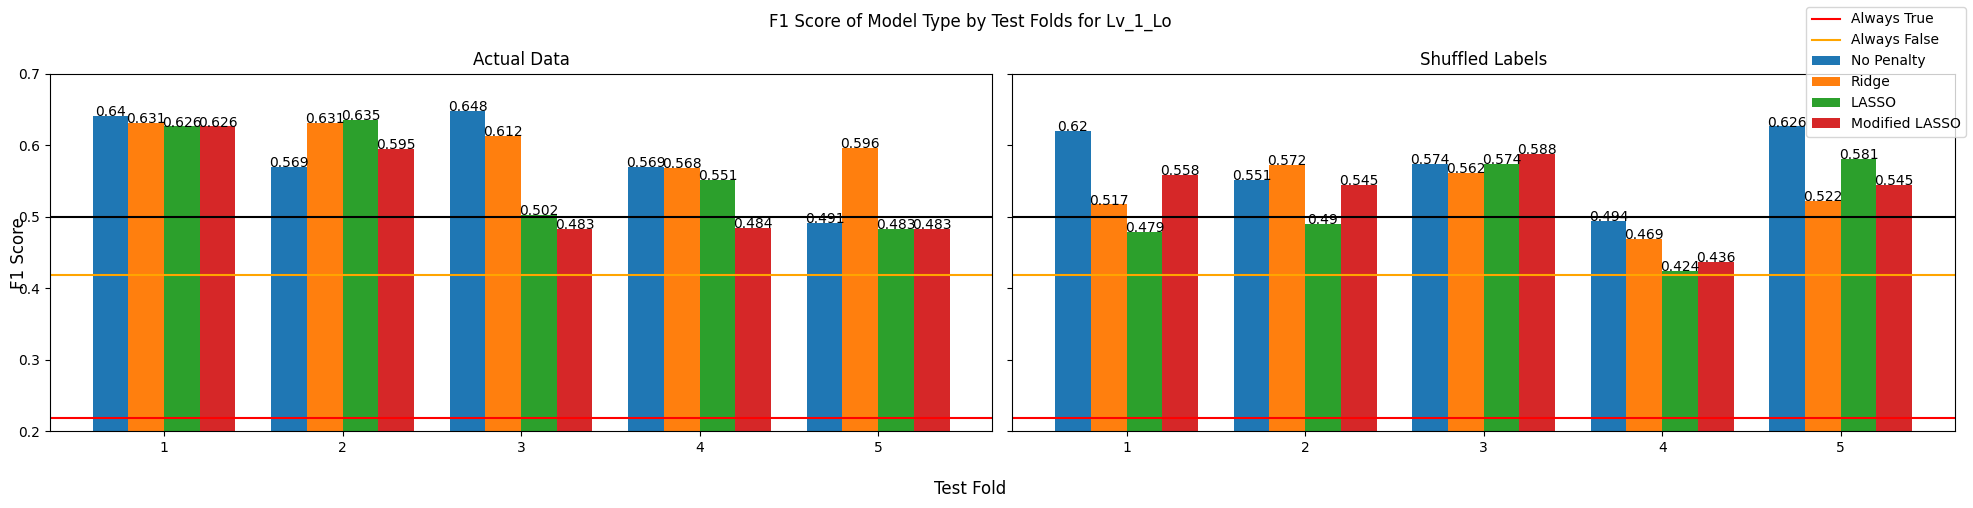

In [5]:
graph_folds(all_f1_scores, all_f1_scores_shuffled, predictors_df, outcomes_df, "Lv_1_Lo", "F1 Score")

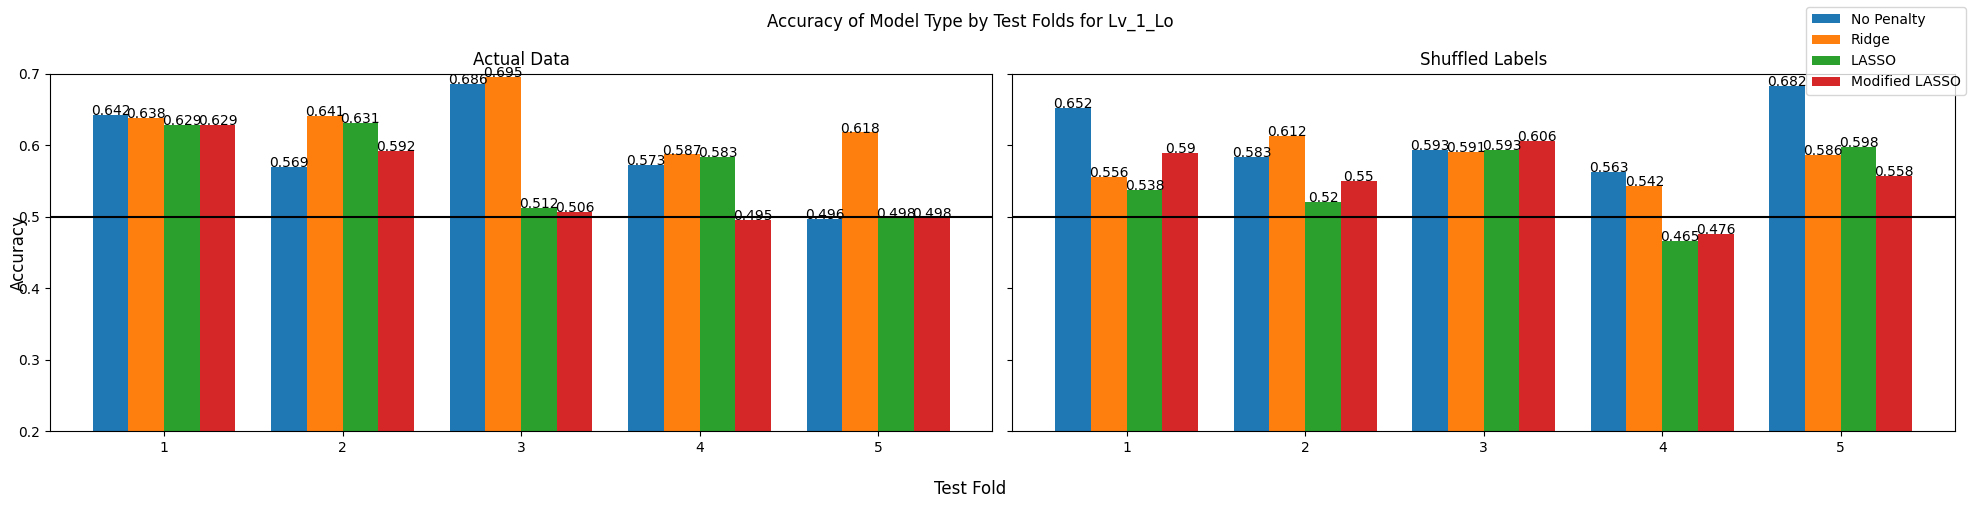

In [6]:
graph_folds(all_accuracy_scores, all_accuracy_scores_shuffled, predictors_df, outcomes_df, "Lv_1_Lo", "Accuracy")

In [ ]:
# Get number of features
print("Actual Data")
for i in range(5):
    print(np.sum(all_CV_models["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(all_CV_models["Lv_1_Lo"]["Relaxed LASSO"][i].coef_[0] != 0))

print("Shuffled")
for i in range(5):
    print(np.sum(all_CV_models_shuffled["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(all_CV_models_shuffled["Lv_1_Lo"]["Relaxed LASSO"][i].coef_[0] != 0))

Actual Data
4588 1897
5922 1788
114 111
102 102
116 113
Shuffled
96 95
101 99
116 113
102 100
111 110


# SA 2

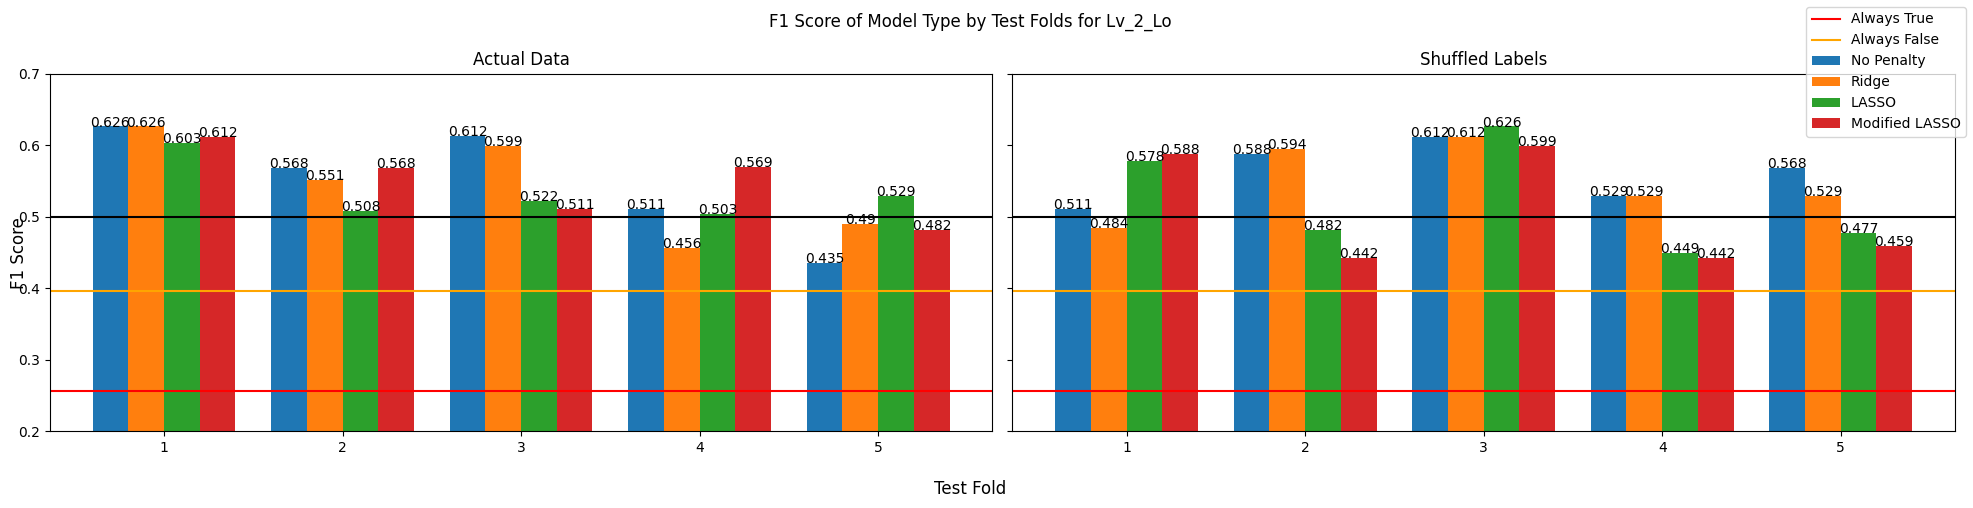

In [7]:
graph_folds(all_f1_scores, all_f1_scores_shuffled, predictors_df, outcomes_df, "Lv_2_Lo", "F1 Score")

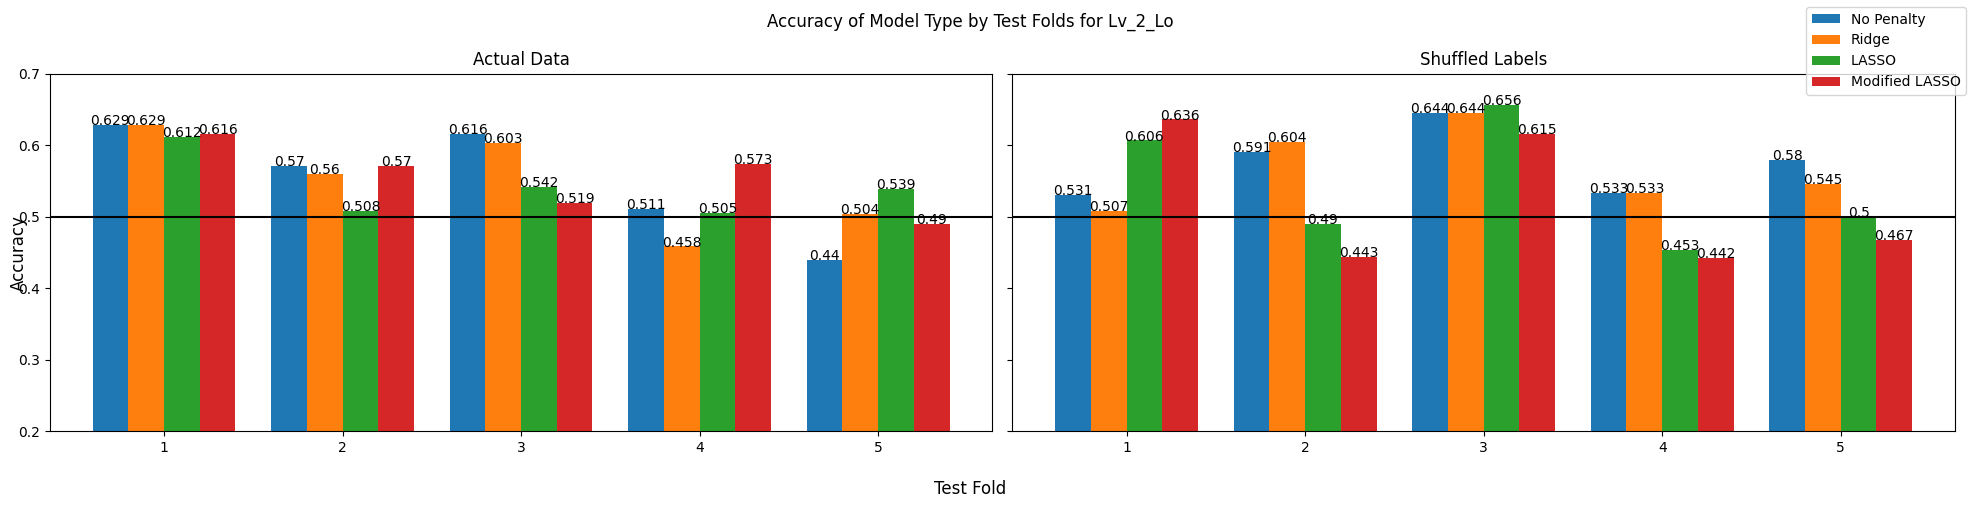

In [8]:
graph_folds(all_accuracy_scores, all_accuracy_scores_shuffled, predictors_df, outcomes_df, "Lv_2_Lo", "Accuracy")

In [32]:
# Get number of features
print("Actual Data")
for i in range(5):
    print(np.sum(all_CV_models["Lv_2_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(all_CV_models["Lv_2_Lo"]["Relaxed LASSO"][i].coef_[0] != 0))

print("Shuffled")
for i in range(5):
    print(np.sum(all_CV_models_shuffled["Lv_2_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(all_CV_models_shuffled["Lv_2_Lo"]["Relaxed LASSO"][i].coef_[0] != 0))

Actual Data
4730 1731
1051 855
118 115
126 124
140 137
Shuffled
97 95
99 97
980 774
115 113
953 812


# SA 3

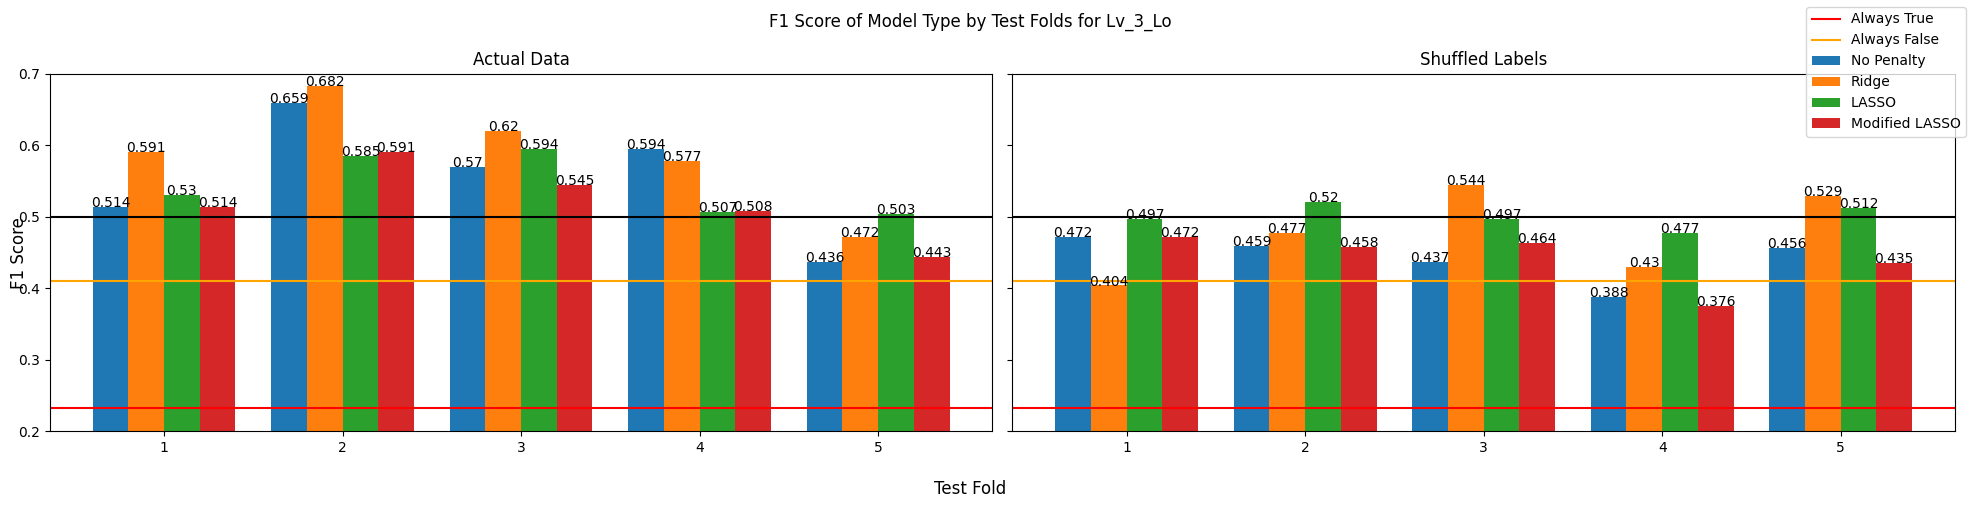

In [9]:
graph_folds(all_f1_scores, all_f1_scores_shuffled, predictors_df, outcomes_df, "Lv_3_Lo", "F1 Score")

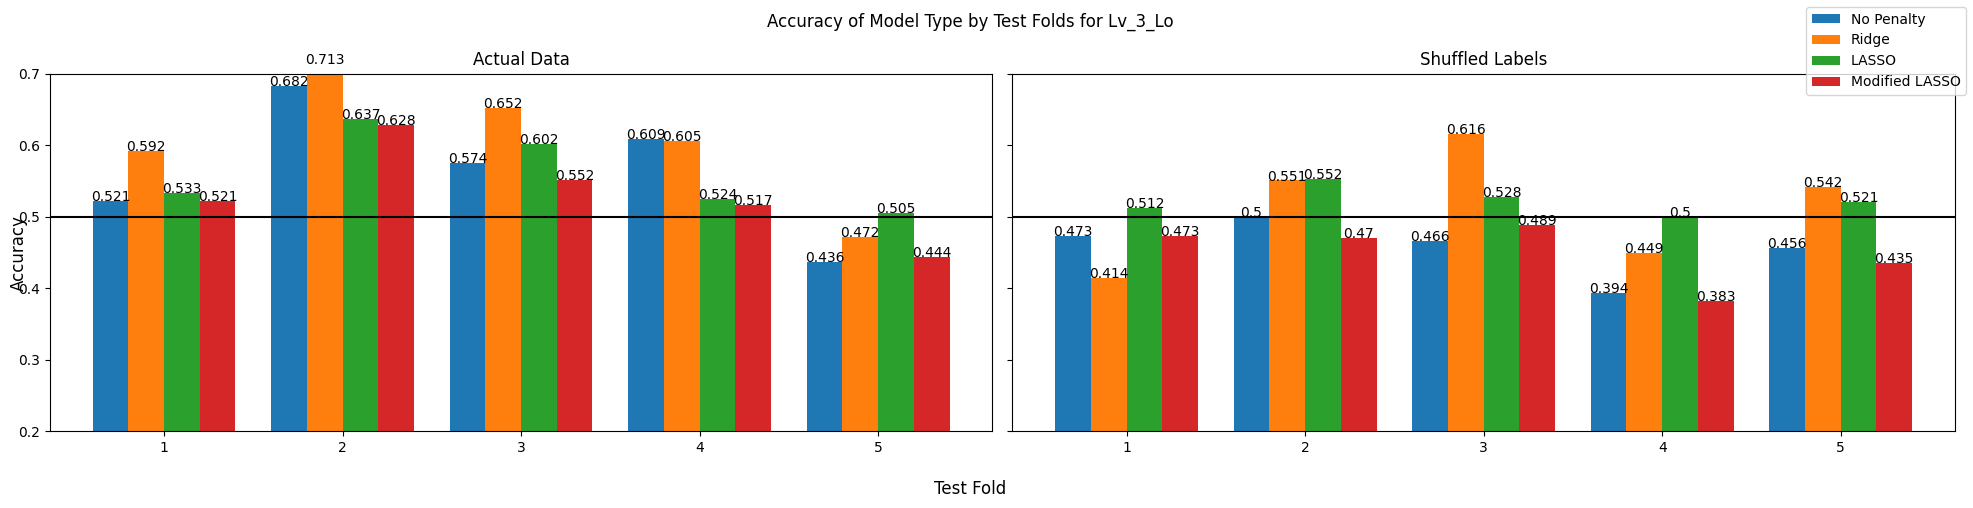

In [10]:
graph_folds(all_accuracy_scores, all_accuracy_scores_shuffled, predictors_df, outcomes_df, "Lv_3_Lo", "Accuracy")

In [36]:
# Get number of features
print("Actual Data")
for i in range(5):
    print(np.sum(all_CV_models["Lv_3_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(all_CV_models["Lv_3_Lo"]["Relaxed LASSO"][i].coef_[0] != 0))

print("Shuffled")
for i in range(5):
    print(np.sum(all_CV_models_shuffled["Lv_3_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(all_CV_models_shuffled["Lv_3_Lo"]["Relaxed LASSO"][i].coef_[0] != 0))

Actual Data
945 821
104 104
1168 987
109 106
90 89
Shuffled
107 103
118 111
114 111
117 117
112 109


# Total SA

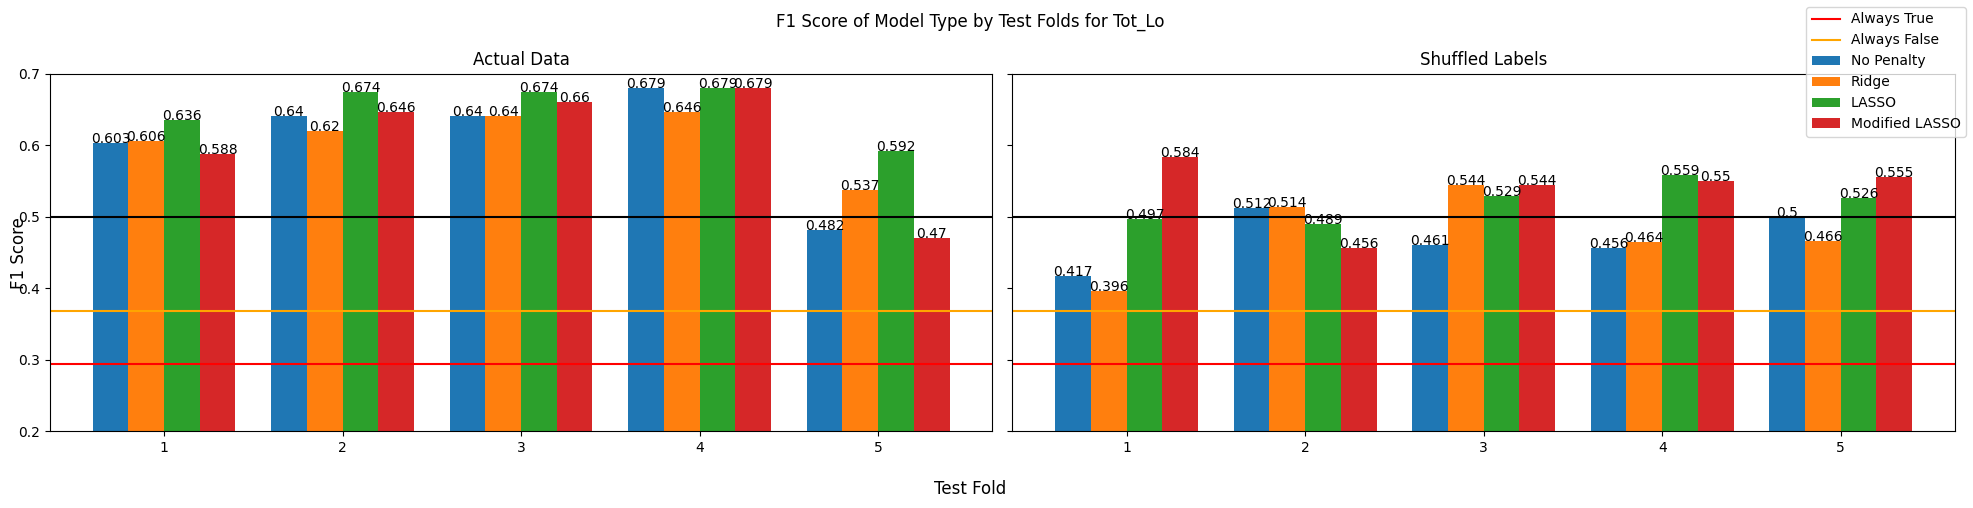

In [11]:
graph_folds(all_f1_scores, all_f1_scores_shuffled, predictors_df, outcomes_df, "Tot_Lo", "F1 Score")

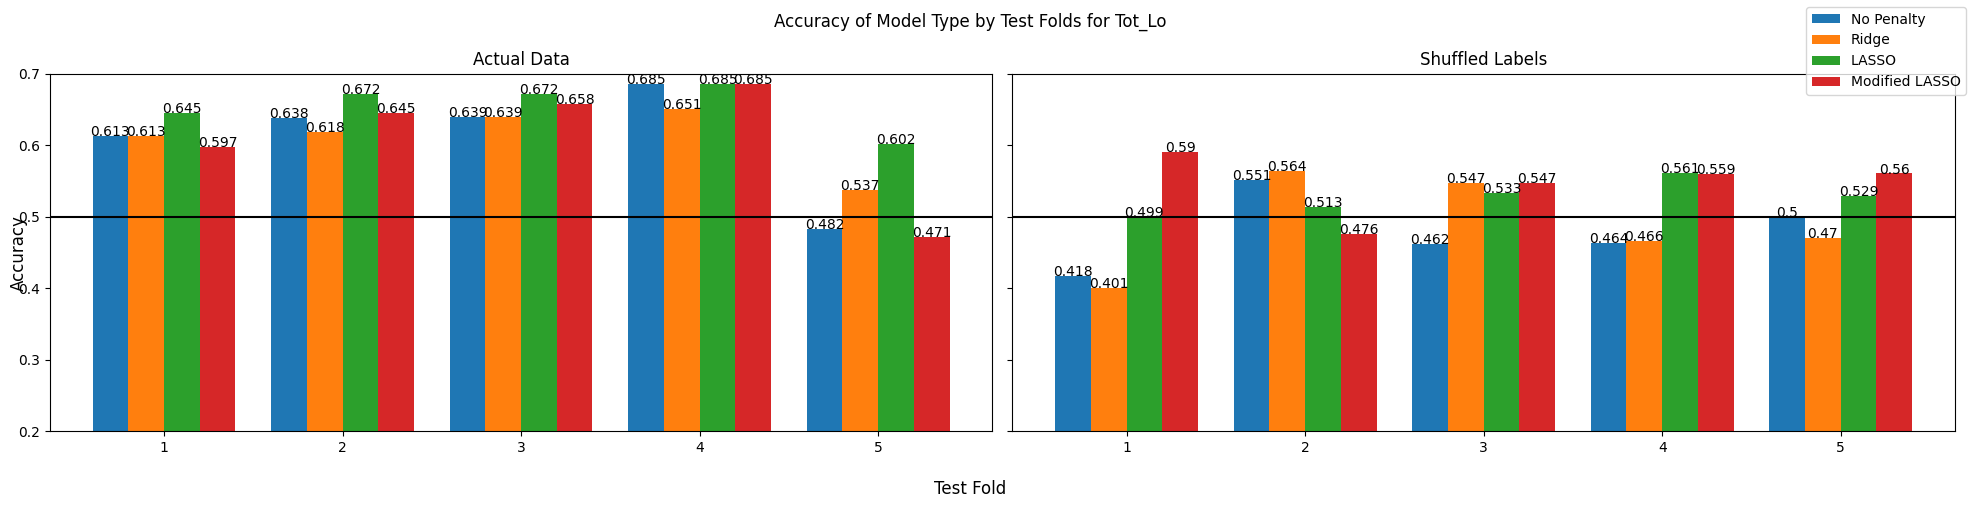

In [12]:
graph_folds(all_accuracy_scores, all_accuracy_scores_shuffled, predictors_df, outcomes_df, "Tot_Lo", "Accuracy")

In [39]:
# Get number of features
print("Actual Data")
for i in range(5):
    print(np.sum(all_CV_models["Tot_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(all_CV_models["Tot_Lo"]["Relaxed LASSO"][i].coef_[0] != 0))

print("Shuffled")
for i in range(5):
    print(np.sum(all_CV_models_shuffled["Tot_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(all_CV_models_shuffled["Tot_Lo"]["Relaxed LASSO"][i].coef_[0] != 0))

Actual Data
4636 1692
4449 1684
5913 1687
1010 839
1082 874
Shuffled
102 100
114 113
123 119
113 111
99 99
